In [5]:
from edgedroid.models import *
import edgedroid.data as e_data
from gabriel_lego import LEGOTask, FrameResult
from tqdm.notebook import tqdm

model = EdgeDroidModel(
    frame_trace=e_data.load_default_trace("square00", truncate=5),
    frame_model=ZeroWaitSamplingPolicy.from_default_data(),
    timing_model=MultiCurveFittingExecutionTimeModel(neuroticism=1.0)
)

task = LEGOTask(e_data.load_default_task("square00", truncate=5))


def generate_latencies(mode: float, rho: float, min_bound: float = 0.0) -> Iterator[float]:
    prev_value = mode
    while True:
        prev_value = np.random.rayleigh(scale=(mode * (1 - rho)) + (prev_value * rho))
        yield min_bound + prev_value


def emulate_run(model: EdgeDroidModel,  rtt_s_iter: Iterator[float], desc: str | None = None):
    step_iter = tqdm(model.play_steps_emulated_time(), total=model.step_count + 1, desc=desc, leave=False)
    
    for model_step in step_iter:
        # in this setup, we have fixed rtts per step
        step_rtt = next(rtt_s_iter)
        
        frame_timings: Optional[FrameTimings] = None
        prev_frame: Optional[str] = None
        while True:
            try:
                model_frame = model_step.send(frame_timings)
            except StopIteration:
                if not prev_frame or prev_frame.lower() not in ("success", "initial"):
                    raise Exception(prev_frame)
                break
            
            # prev_result = task.submit_frame(model_frame.frame_data)
            prev_frame = model_frame.frame_tag
            frame_timings = FrameTimings(step_rtt * 0.9, step_rtt * 0.1)
            

emulate_run(model, generate_latencies(3.2, rho=.2, min_bound=0.1))
model.model_step_metrics()

  0%|          | 0/6 [00:00<?, ?it/s]

,last_frame_rtt,execution_time,step_duration,time_to_feedback,wait_time,frame_count
step_number,,,,,,
0,3.674125,0.000000,3.674125,3.674125,0.000000,1
1,4.668397,5.923502,14.005190,8.081688,3.413291,3
2,4.872649,6.628337,14.617946,7.989610,3.116961,3
3,2.962270,6.628337,11.849079,5.220742,2.258473,4
4,6.043213,6.628337,18.129638,11.501301,5.458089,3
5,6.732810,6.628337,13.465619,6.837283,0.104473,2


In [6]:
import itertools as it

trace = "square00"
truncate = 50
reps_per_model = 20
rep_offset = 10

class ThirdDegPolyExecutionTimeModel(MultiCurveFittingExecutionTimeModel):
    _fit_functions = (CubeFit, )

timing_models = {
    "3rd-poly-high": lambda : ThirdDegPolyExecutionTimeModel(neuroticism=1.0),
    "3rd-poly-low": lambda : ThirdDegPolyExecutionTimeModel(neuroticism=0.0),
    "legacy": lambda : LegacyModel(),
    "first-order": lambda : FirstOrderETM(),
    "first-order-median": lambda : FirstOrderAggregateETM(np.median)
}

min_bound = 0.042 # 24FPS

rho_vals = (
    0.0, 
    0.25, 
    0.5,
    # 0.6,
    # 0.7,
    # 0.8,
)
sigma_vals = (
    0.1, 
    0.2, 
    0.4, 
    0.8, 
    1.6, 
    # 3.2
)

dfs = deque()

params_iter = tqdm(list(it.product(
    timing_models.items(),
    range(rep_offset, reps_per_model + rep_offset),
    rho_vals,
    sigma_vals
)), desc="Parameter combinations")
for (model_name, model_constructor), rep, rho, sigma in params_iter:
    model = EdgeDroidModel(
        frame_trace=e_data.load_default_trace(trace, truncate=truncate),
        frame_model=ZeroWaitSamplingPolicy.from_default_data(),
        timing_model=model_constructor()
    )

    # task = LEGOTask(e_data.load_default_task(trace, truncate=truncate))
    
    desc = f"{model_name} {rho=} {sigma=} ({rep + 1}/{reps_per_model + rep_offset})"
    emulate_run(model, generate_latencies(sigma, rho, min_bound=min_bound), desc=desc)
    
    df = model.model_step_metrics()
    df["model"] = model_name
    df["rep"] = rep
    df["rho"] = rho
    df["sigma"] = sigma
    
    dfs.append(df)
    
data = pd.concat(dfs)
data.to_csv("./per_step_delay.csv")
data

Parameter combinations:   0%|          | 0/1500 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x16a9bfec0>
Traceback (most recent call last):
  File "/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


3rd-poly-high rho=0.5 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.0 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.25 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-high rho=0.5 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.0 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.25 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

3rd-poly-low rho=0.5 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.0 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.25 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.5 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.0 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.25 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.5 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (11/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (12/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (13/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (14/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (15/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (16/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (17/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (18/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (19/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (20/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (21/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (22/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (23/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (24/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (25/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (26/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (27/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (28/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (29/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.0 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.25 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.1 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.2 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.4 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=0.8 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.5 sigma=1.6 (30/30):   0%|          | 0/51 [00:00<?, ?it/s]

,last_frame_rtt,execution_time,step_duration,time_to_feedback,wait_time,frame_count,model,rep,rho,sigma
step_number,,,,,,,,,,
0,0.254864,0.000000,0.254864,0.254864,0.000000,1,3rd-poly-high,10,0.0,0.1
1,0.198604,5.046566,5.362305,0.315739,0.117135,27,3rd-poly-high,10,0.0,0.1
2,0.107445,5.067793,5.264792,0.196999,0.089555,49,3rd-poly-high,10,0.0,0.1
3,0.253242,5.025240,5.318076,0.292836,0.039594,21,3rd-poly-high,10,0.0,0.1
4,0.154361,4.720658,4.939558,0.218900,0.064539,32,3rd-poly-high,10,0.0,0.1
...,...,...,...,...,...,...,...,...,...,...
46,1.677522,5.230947,8.387612,3.156665,1.479143,5,first-order-median,29,0.5,1.6
47,3.020265,5.230947,9.060794,3.829847,0.809582,3,first-order-median,29,0.5,1.6
48,1.223193,5.230947,7.339158,2.108211,0.885018,6,first-order-median,29,0.5,1.6


In [7]:
data = pd.read_csv("per_step_delay.csv")
models = pd.CategoricalDtype(["3rd-poly-low", "3rd-poly-high", "legacy", "first-order", "first-order-median"], ordered=False)
data["model"] = data["model"].astype(models)
data = data[data["rho"] < 0.8]
data = data[data["sigma"] < 3.2]

rho_sigma_dtype = pd.CategoricalDtype(map(lambda t: f"{t[0]} {t[1]}", itertools.product(sorted(data["rho"].unique()), sorted(data["sigma"].unique()))), ordered=True)

data["rho"] = data["rho"].astype("category")
data["sigma"] = data["sigma"].astype("category")


data["rho_sigma"] = data[["rho", "sigma"]].apply(func=lambda row: f"{row.rho} {row.sigma}", axis=1).astype(rho_sigma_dtype)
data



,step_number,last_frame_rtt,execution_time,step_duration,time_to_feedback,wait_time,frame_count,model,rep,rho,sigma,rho_sigma
0,0,0.254864,0.000000,0.254864,0.254864,0.000000,1,3rd-poly-high,10,0.0,0.1,0.0 0.1
1,1,0.198604,5.046566,5.362305,0.315739,0.117135,27,3rd-poly-high,10,0.0,0.1,0.0 0.1
2,2,0.107445,5.067793,5.264792,0.196999,0.089555,49,3rd-poly-high,10,0.0,0.1,0.0 0.1
3,3,0.253242,5.025240,5.318076,0.292836,0.039594,21,3rd-poly-high,10,0.0,0.1,0.0 0.1
4,4,0.154361,4.720658,4.939558,0.218900,0.064539,32,3rd-poly-high,10,0.0,0.1,0.0 0.1
...,...,...,...,...,...,...,...,...,...,...,...,...
76495,46,1.677522,5.230947,8.387612,3.156665,1.479143,5,first-order-median,29,0.5,1.6,0.5 1.6
76496,47,3.020265,5.230947,9.060794,3.829847,0.809582,3,first-order-median,29,0.5,1.6,0.5 1.6
76497,48,1.223193,5.230947,7.339158,2.108211,0.885018,6,first-order-median,29,0.5,1.6,0.5 1.6
76498,49,2.022367,5.230947,8.089468,2.858521,0.836154,4,first-order-median,29,0.5,1.6,0.5 1.6


In [8]:
total_durations = data.groupby(["model", "rep", "rho", "sigma", "rho_sigma"], observed=True)["step_duration"].sum().reset_index()
total_durations

,model,rep,rho,sigma,rho_sigma,step_duration
0,3rd-poly-low,10,0.0,0.1,0.0 0.1,195.477035
1,3rd-poly-low,10,0.0,0.2,0.0 0.2,235.184298
2,3rd-poly-low,10,0.0,0.4,0.0 0.4,296.725570
3,3rd-poly-low,10,0.0,0.8,0.0 0.8,340.202125
4,3rd-poly-low,10,0.0,1.6,0.0 1.6,441.896289
...,...,...,...,...,...,...
1495,first-order-median,29,0.5,0.1,0.5 0.1,276.391213
1496,first-order-median,29,0.5,0.2,0.5 0.2,286.695289
1497,first-order-median,29,0.5,0.4,0.5 0.4,324.759393
1498,first-order-median,29,0.5,0.8,0.5 0.8,345.715859


mean duration


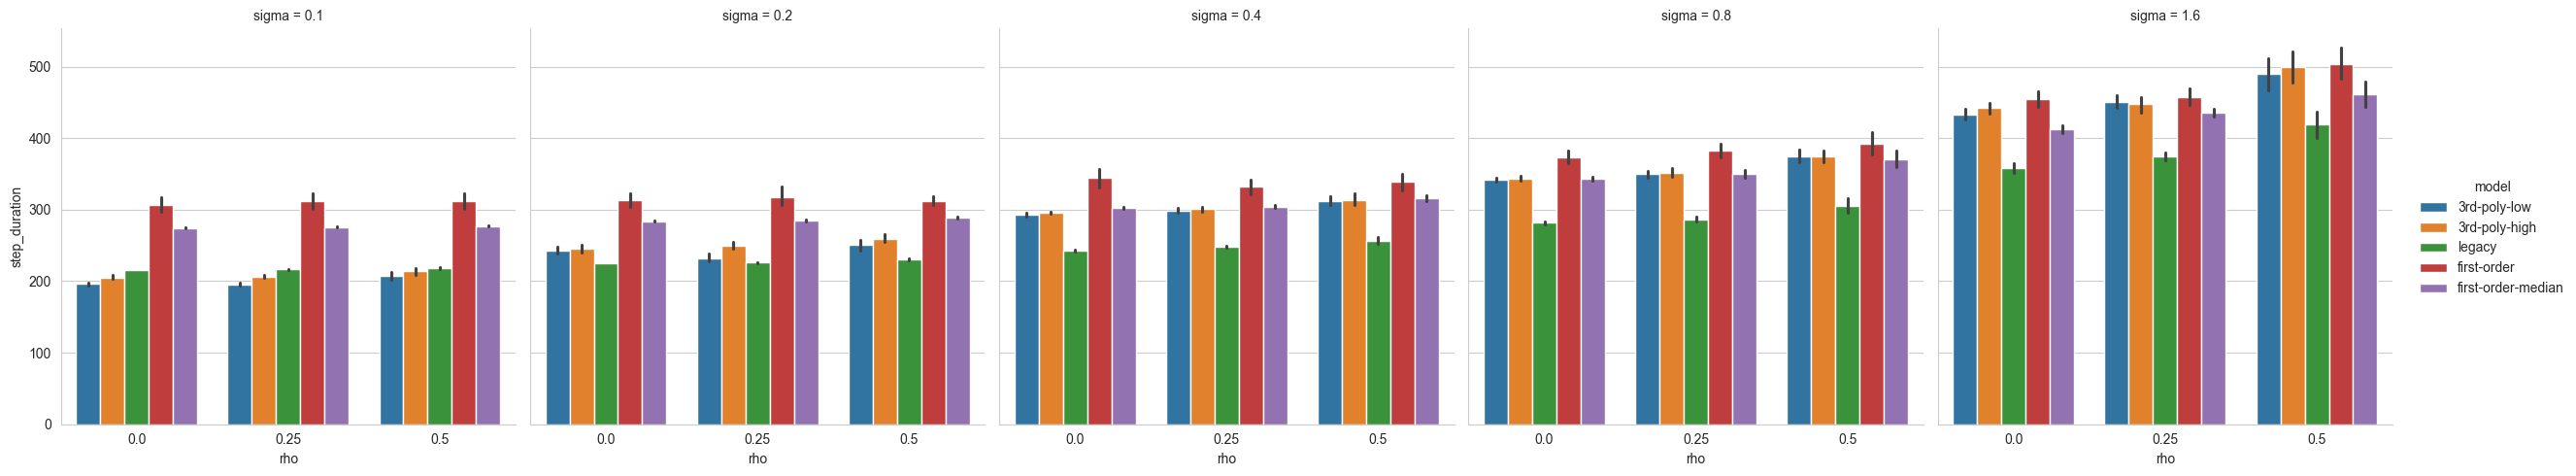

In [14]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

print("mean duration")
fg = sns.catplot(kind="bar", data=total_durations, hue="model", y="step_duration", col="sigma", x="rho")
# fg.set(yscale="log")
plt.show()

# push correlation higher

mean number of frames


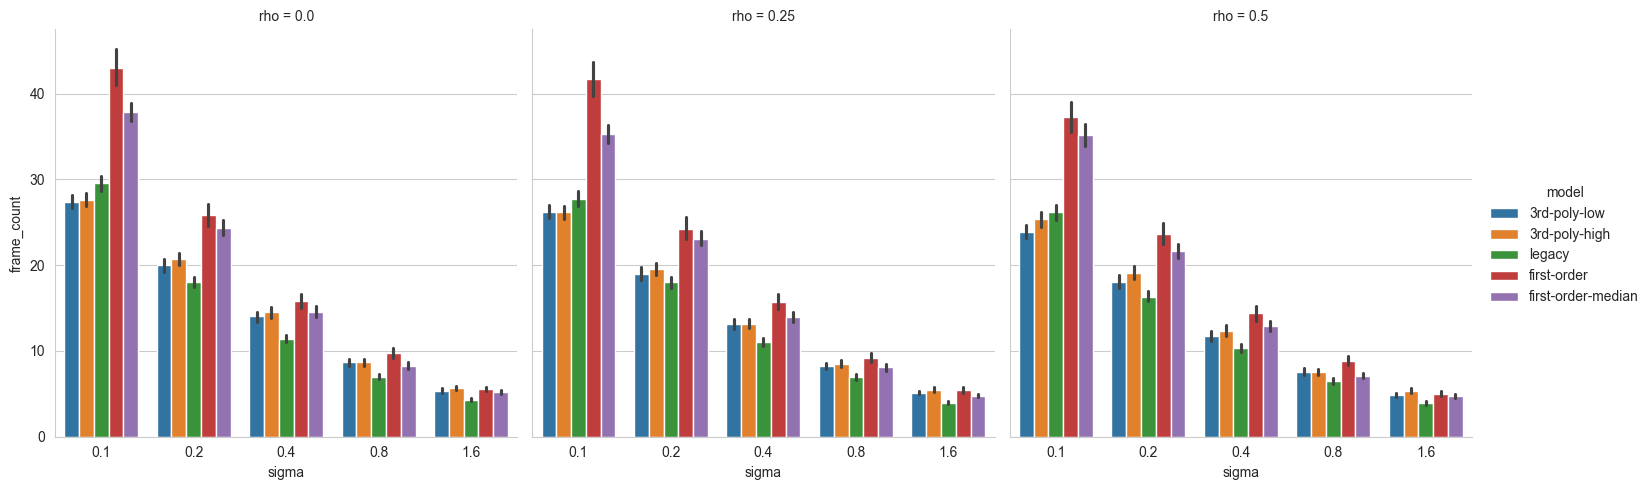

In [10]:
print("mean number of frames")
fg = sns.catplot(kind="bar", data=data, y="frame_count", hue="model", x="sigma", col="rho")
plt.show()

mean TTF


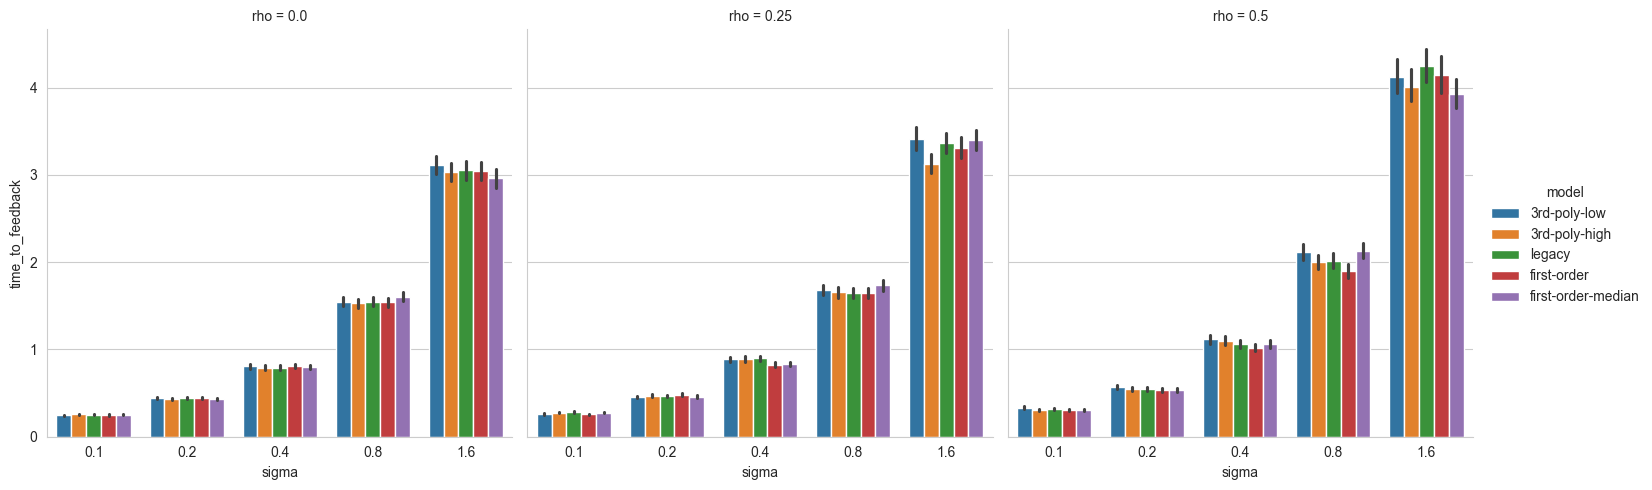

In [11]:
print("mean TTF")
fg = sns.catplot(kind="bar", data=data, hue="model", y="time_to_feedback", x="sigma", col="rho")
plt.show()

mean wait time


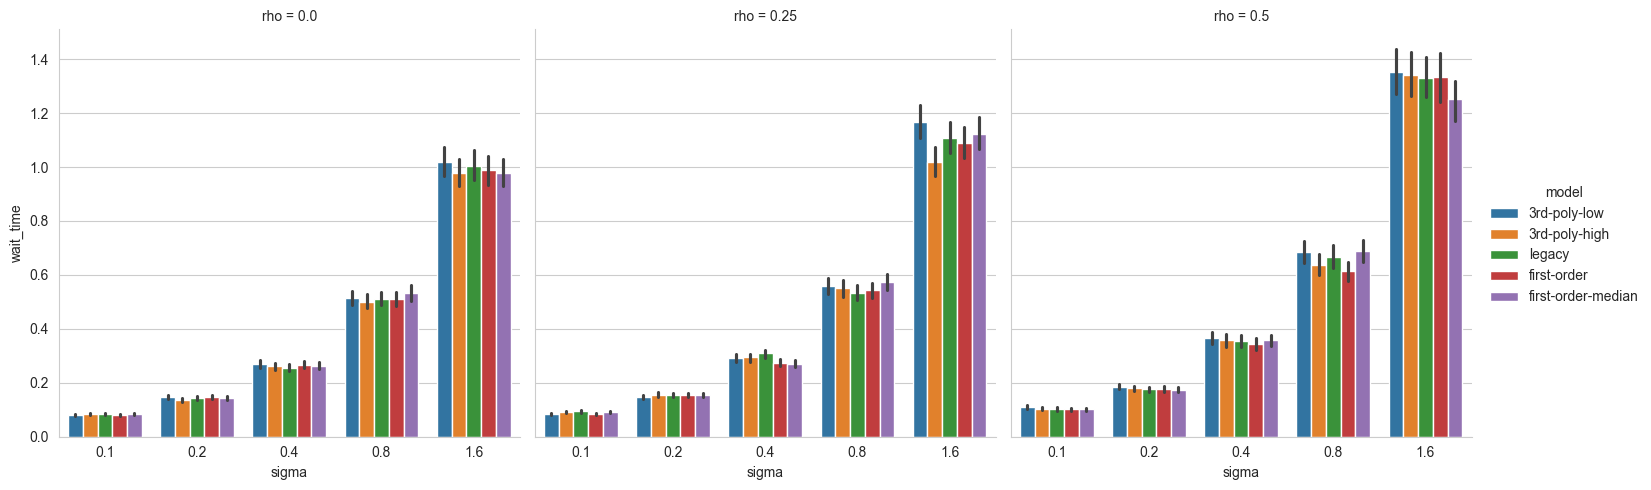

In [12]:
print("mean wait time")
fg = sns.catplot(kind="bar", data=data, hue="model", y="wait_time", x="sigma", col="rho")
plt.show()

mean last frame rtt


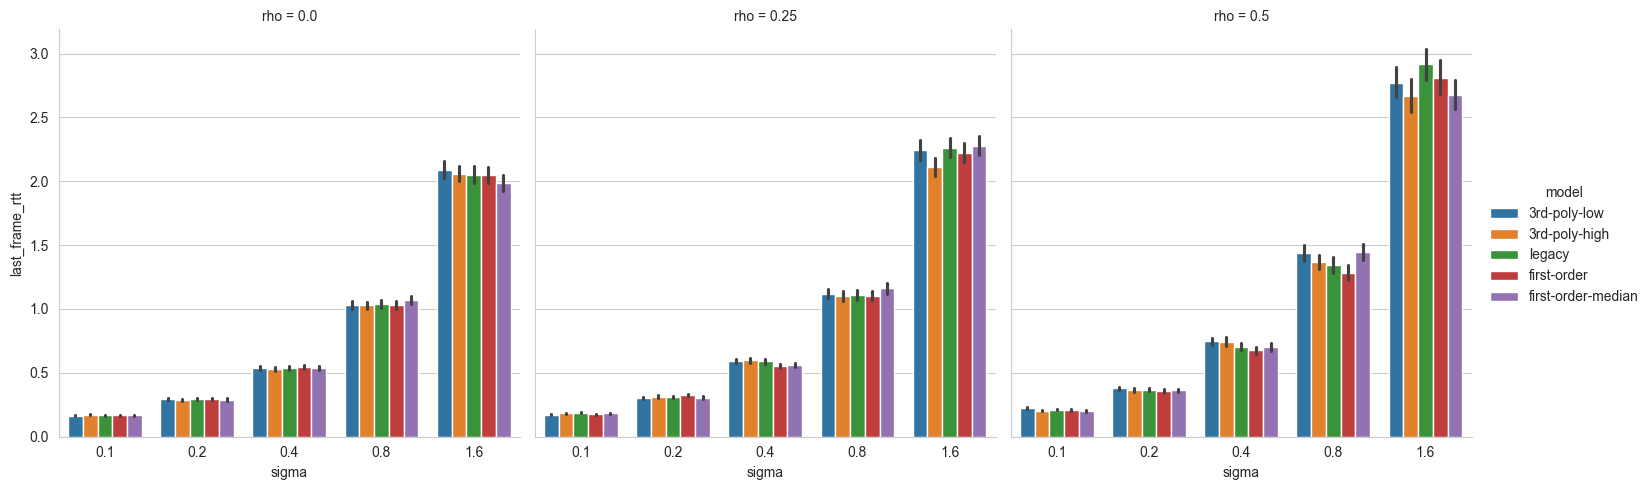

In [13]:
print("mean last frame rtt")
fg = sns.catplot(kind="bar", data=data, hue="model", y="last_frame_rtt", x="sigma", col="rho")
plt.show()